In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from trimesh import *
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from plyfile import PlyData
import polyscope as ps

# Read input
plydata = PlyData.read("cut2.ply")
X = np.vstack((
    plydata['vertex']['x'],
    plydata['vertex']['y'],
    plydata['vertex']['z']
)).T

ITris = np.array(list(plydata['face']['vertex_indices']), dtype=int)

<IPython.core.display.Javascript object>


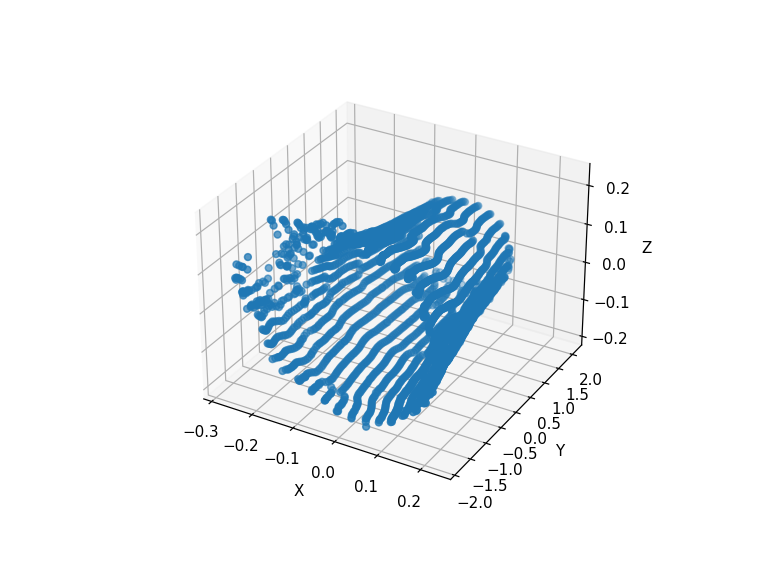

Text(0.5, 0, 'Z')

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [4]:
#import robust_laplacian
#import scipy.sparse.linalg as sla
#L, M = robust_laplacian.point_cloud_laplacian(X)
from scipy import sparse
from scipy.sparse.csgraph import dijkstra


def tris2edges(tris):
    idxs = np.array([], dtype=int)
    N = np.max(tris+1)
    for k in range(3):
        idxs_k = np.ravel_multi_index((tris[:, k], tris[:, (k+1)%3]), (N, N))
        idxs = np.concatenate((idxs, idxs_k))
    idxs = np.unique(idxs)
    idxs = np.unravel_index(idxs, (N, N))
    return np.array(idxs, dtype=int).T

edges = tris2edges(ITris)
print(ITris.shape)
d = np.sqrt(np.sum((X[edges[:, 0], :] - X[edges[:, 1], :])**2, axis=1))
N = X.shape[0]
D = sparse.coo_matrix((d, (edges[:, 0], edges[:, 1])), shape=(N, N))
D = sparse.csr_matrix(D)


dist_matrix, predecessors = dijkstra(csgraph=D, directed=False,return_predecessors=True)

(5746, 3)


In [5]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')
Y = embedding.fit_transform(dist_matrix)

In [6]:
mean = np.mean(Y, axis=0)
Y -= mean
print(mean)
pca = PCA(n_components=2)
Z = pca.fit_transform(Y)

[-3.59620543e-16  4.88468545e-16]


<IPython.core.display.Javascript object>


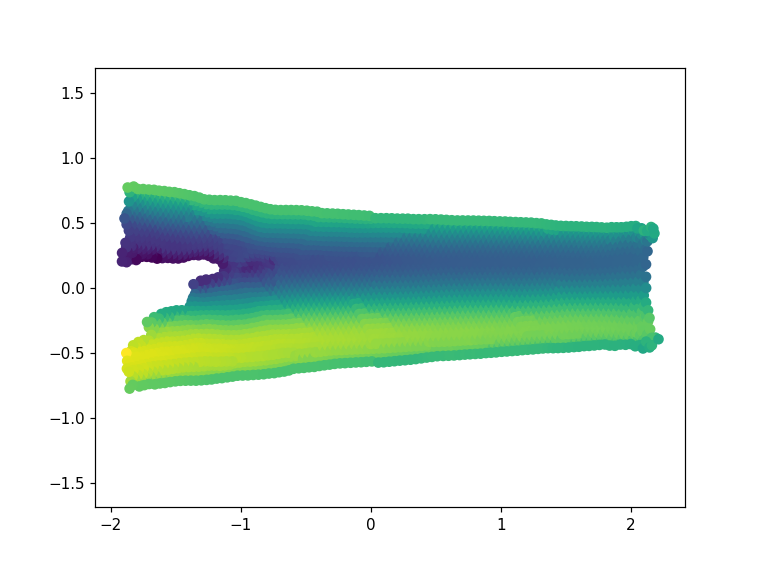

(-2.117910973603771,
 2.4183275474059394,
 -0.8525395908692486,
 0.8557668193125848)

In [7]:
plt.figure()
plt.scatter(Z[:, 0], Z[:, 1], c=X[:, 0])
plt.axis("equal")

In [8]:
fin = open("cut2.obj")
lines = fin.readlines()
fin.close()
fout = open("cut2_flat.obj", "w")
idx = 0
for l in lines:
    l = l.rstrip()
    if l[0:2] == "f ":
        fields = l.split()[1::]
        s = "f "
        for f in fields:
            x = f.split("/")
            s += x[0] + "/" + x[1] + " "
        fout.write(s + "\n")
    elif l[0:2] == "v ":
        y, x = Z[idx, :]
        fout.write("v {:.6f} {:.6f} {:.6f}\n".format(x, y, 0))
        idx += 1
    elif l[0:2] == "vn":
        continue
    else:
        fout.write(l + "\n")
fout.close()